## CLustering pipeline

- Run on the 3hvc protein



In [1]:
# Define data path
data_path = "/Users/nicha/dev/Protein-preparation-pipeline/data/toy_examples_clustering"

# System and OS utilities
import os
import sys

# Numerical and Data Processing
import numpy as np
import pandas as pd

# Scientific and Bioinformatics Tools
from math import e
from pymol import cmd, stored
import numpy as np
from Bio import PDB
from scipy.spatial import distance_matrix, KDTree
from scipy.stats import shapiro
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import combinations


# Machine Learning & Clustering
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import py3Dmol

# Color Mapping for Visualization
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.linalg import eigh
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import kneighbors_graph

# Add project-specific source path
sys.path.append('/Users/nicha/dev/Protein-preparation-pipeline/src/')

# Custom Modules from Your Project
from pdb_retrival.data_retriever import PDBDataRetriever

In [2]:
# Function for the data preparation

# 1️⃣ Extract residue coordinates from PDB
def extract_residue_coordinates(pdb_file, residue_number, chain_id="A"):
    """
    Extracts atomic coordinates for a given residue from a PDB file.

    Args:
        pdb_file (str): Path to the PDB file.
        residue_number (int): Residue number to extract.
        chain_id (str): Chain ID of the residue.

    Returns:
        list: List of tuples (atom_type, x, y, z).
    """
    coordinates = []
    try:
        with open(pdb_file, "r") as file:
            for line in file:
                if line.startswith(("ATOM", "HETATM")) and line[21] == chain_id:
                    resi = int(line[22:26].strip())
                    if resi == residue_number:
                        atom_type = line[76:78].strip()
                        x = float(line[30:38].strip())
                        y = float(line[38:46].strip())
                        z = float(line[46:54].strip())
                        coordinates.append((atom_type, x, y, z))
    except FileNotFoundError:
        print(f"Error: File {pdb_file} not found.")
    except Exception as e:
        print(f"Unexpected error: {e}")
    return coordinates


# 2️⃣ Compute Weighted Center of Mass
def calculate_weighted_center_of_mass(coordinates):
    """
    Calculates the weighted center of mass for a given set of atomic coordinates.

    Args:
        coordinates (list): List of tuples (atom_type, x, y, z).

    Returns:
        list: [x, y, z] coordinates of the weighted center of mass.
    """
    total_weight = 0
    weighted_coords = np.zeros(3)
    atomic_weights = {"H": 1.008, "C": 12.011, "N": 14.007, "O": 15.999, "S": 32.06}

    for atom_type, x, y, z in coordinates:
        weight = atomic_weights.get(atom_type.upper(), 1.0)
        weighted_coords += np.array([x, y, z]) * weight
        total_weight += weight

    return np.round(weighted_coords / total_weight, 3).tolist()


# 3️⃣ Process a Single PDB File and Update the DataFrame
def process_pdb_file(data_path, pdb_code, df):
    """
    Reads a PDB file and updates a DataFrame with residue center of mass.

    Args:
        data_path (str): Path to the directory containing the PDB and CSV files.
        pdb_code (str): PDB code of the protein.
        df (pd.DataFrame): DataFrame containing residue data.

    Returns:
        pd.DataFrame: Updated DataFrame with center of mass information.
    """
    pdb_file = os.path.join(data_path, f"{pdb_code}.pdb")

    try:
        for index, row in df.iterrows():
            residue_number = row["resi"]
            chain_id = row["chain"]
            coordinates = extract_residue_coordinates(pdb_file, residue_number, chain_id)
            if coordinates:
                center_of_mass = calculate_weighted_center_of_mass(coordinates)
                df.loc[index, "resn_coordinates"] = str(coordinates)
                df.loc[index, ["center_of_mass_x", "center_of_mass_y", "center_of_mass_z"]] = center_of_mass
            else:
                print(f"Residue {residue_number} in chain {chain_id} not found in {pdb_file}.")
    except FileNotFoundError:
        print(f"Error: {pdb_file} not found.")
    except Exception as e:
        print(f"Unexpected error: {e}")

    return df


# 4️⃣ Process and Update Data for a Single PDB Structure
def process_and_update_pdb_data(data_path, pdb_code):
    """
    Reads and processes a PDB file and corresponding CSV file to update residue information.

    Args:
        data_path (str): Path to the directory containing the PDB and CSV files.
        pdb_code (str): PDB code of the protein.

    Returns:
        pd.DataFrame: Updated DataFrame with residue information.
    """
    csv_file_path = f"{data_path}/results_{pdb_code}.csv"

    try:
        df = pd.read_csv(csv_file_path)
        df_updated = process_pdb_file(data_path, pdb_code, df)
        df_updated.to_csv(f"{data_path}/results_{pdb_code}_updated.csv", index=False)
        return df_updated
    except Exception as e:
        print(f"Error processing {pdb_code}: {e}")
        return None


# 5️⃣ Process All PDB Files in a Directory
def process_all_pdb_files(data_path):
    """
    Process all PDB-related files in the given directory and combine results.

    Args:
        data_path (str): Path to the directory containing the PDB and CSV files.

    Returns:
        pd.DataFrame: Combined DataFrame with all processed data.
    """
    combined_df = pd.DataFrame()

    for file in os.listdir(data_path):
        if file.startswith("results_") and file.endswith(".csv"):
            pdb_code = file.split("_")[1].split(".")[0]
            updated_df = process_and_update_pdb_data(data_path, pdb_code)
            if updated_df is not None:
                updated_df["PDBcode"] = pdb_code
                combined_df = pd.concat([combined_df, updated_df], ignore_index=True)

    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(f"{data_path}/combined_results.csv", index=False)
    return combined_df


# 6️⃣ Compute Center of Protein Using PyMOL
def calculate_center_of_mass_pymol(pdb_file):
    """
    Calculates the center of mass of a protein using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        tuple: (x, y, z) coordinates of the protein's center of mass.
    """
    cmd.load(pdb_file, "protein")
    center_of_mass = cmd.centerofmass("protein")
    cmd.delete("all")
    return round(center_of_mass[0], 3), round(center_of_mass[1], 3), round(center_of_mass[2], 3)


# 7️⃣ Compute Protein Diameter
def calculate_protein_diameter(df):
    """
    Computes the diameter of a protein, defined as the maximum distance between residues.

    Args:
        df (pd.DataFrame): DataFrame containing residue data with center of mass coordinates.

    Returns:
        float: Maximum distance between residues.
    """
    coordinates = df[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].values
    distances = np.linalg.norm(coordinates[:, np.newaxis] - coordinates, axis=2)
    return round(np.max(distances), 3)


# 8️⃣ Process Protein Data for a Single PDB
def process_protein_data(pdb_code, dfs, data_path):
    """
    Processes protein data by computing center of mass and diameter.

    Args:
        pdb_code (str): The PDB code of the protein.
        dfs (dict): Dictionary containing DataFrames indexed by PDB code.
        data_path (str): Path to the directory containing the PDB files.

    Returns:
        pd.DataFrame: Updated DataFrame with center of protein and diameter.
    """
    pdb_file_path = f"{data_path}/{pdb_code}.pdb"
    df = dfs[pdb_code]
    center_of_mass = calculate_center_of_mass_pymol(pdb_file_path)
    protein_diameter = calculate_protein_diameter(df)

    df["protein_x"], df["protein_y"], df["protein_z"] = center_of_mass
    df["protein_diameter"] = protein_diameter

    return df



def normalize_features(df, feature_columns):
    """
    Normalize or standardize features based on their distribution.

    - **Standardizes (Z-score) if normally distributed**.
    - **Normalizes (Min-Max) if not normally distributed**.
    - **Adds new columns instead of replacing existing ones**.
    - **Stores scalers for consistent transformation in clustering**.

    Args:
        df (pd.DataFrame): DataFrame containing features.
        feature_columns (list): List of feature column names (e.g., 3D coordinates).

    Returns:
        pd.DataFrame: DataFrame with added transformed feature columns.
        dict: Dictionary of fitted scalers (for later reuse).
    """
    processed_df = df.copy()
    scalers = {}

    for col in feature_columns:
        stat, p_value = shapiro(df[col].dropna())  # Test normality
        
        if p_value > 0.05:  
            scaler = StandardScaler()  # Standardization if normal
            new_col_name = f"{col}_standardized"
        else:  
            scaler = MinMaxScaler()  # Normalization if not normal
            new_col_name = f"{col}_normalized"

        processed_df[new_col_name] = scaler.fit_transform(df[[col]])  # Apply transformation
        scalers[col] = scaler  # Store scaler for reuse

    return processed_df, scalers


def weighted_pbind(df, pbind_column='p(bind)', weights=[1.0]):
    """
    Normalize and apply multiple weight factors to p(bind).

    - **Scales p(bind) between 0 and 1**.
    - **Applies multiple weight factors** to create additional columns.
    - **Adds new columns instead of replacing p(bind)**.
    - **Stores scaler** for reuse in clustering.

    Args:
        df (pd.DataFrame): DataFrame containing p(bind).
        pbind_column (str): Column name for p(bind).
        weights (list): List of weight multipliers (e.g., [1.0, 5.0, 10.0, 100.0]).

    Returns:
        pd.DataFrame: DataFrame with weighted p(bind) columns.
        dict: Dictionary of fitted scalers.
    """
    processed_df = df.copy()
    scalers = {}

    if pbind_column in df.columns:
        scaler = MinMaxScaler()
        normalized_pbind = scaler.fit_transform(df[[pbind_column]])  # Scale to 0-1
        scalers[pbind_column] = scaler  # Store scaler

        for weight in weights:
            weighted_col_name = f"{pbind_column}_weight_{weight}"
            processed_df[weighted_col_name] = normalized_pbind * weight  # Apply weight

    return processed_df, scalers
    """
    Normalize and apply multiple weight factors to p(bind).

    - **Scales p(bind) between 0 and 1**.
    - **Applies multiple weight factors** to create additional columns.
    - **Stores scaler** for reuse in clustering.

    Args:
        df (pd.DataFrame): DataFrame containing p(bind).
        pbind_column (str): Column name for p(bind).
        weights (list): List of weight multipliers (e.g., [1.0, 1.5, 2.0]).

    Returns:
        pd.DataFrame: DataFrame with weighted p(bind) columns.
        dict: Dictionary of fitted scalers.
    """
    processed_df = df.copy()
    scalers = {}

    if pbind_column in df.columns:
        scaler = MinMaxScaler()
        normalized_pbind = scaler.fit_transform(df[[pbind_column]])  # Scale to 0-1
        scalers[pbind_column] = scaler  # Store scaler

        for weight in weights:
            weighted_col_name = f"{pbind_column}_weight_{weight}"
            processed_df[weighted_col_name] = normalized_pbind * weight  # Apply weight

    return processed_df, scalers


In [3]:
# Function to evaluate the clustering performance
def calculate_protein_center_of_mass(pdb_file):
    """
    Calculate the center of mass of the entire protein using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        tuple: Center of mass coordinates (x, y, z).
    """
    cmd.load(pdb_file, "protein")
    center_of_mass = cmd.centerofmass("protein")
    cmd.delete("all")  # Clear the loaded structure
    return tuple(round(coord, 3) for coord in center_of_mass)

def calculate_cluster_centers(df, cluster_column, pdb_file):
    """
    Calculate the center of mass for each cluster using PyMOL.

    Args:
        df (pd.DataFrame): DataFrame containing residue and cluster information.
        cluster_column (str): Column name containing cluster IDs.
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Cluster IDs as keys and their center of mass coordinates as values.
    """
    cmd.load(pdb_file, "protein")
    cluster_centers = {}
    clusters = df[cluster_column].unique()

    for cluster_id in clusters:
        cluster_data = df[df[cluster_column] == cluster_id]
        resi_selection = "+".join(map(str, cluster_data['resi']))
        cmd.select(f"cluster_{cluster_id}", f"resi {resi_selection}")
        center_of_mass = cmd.centerofmass(f"cluster_{cluster_id}")
        cluster_centers[cluster_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete(f"cluster_{cluster_id}")

    cmd.delete("all")  # Clear the loaded structure
    return cluster_centers

def calculate_ligand_centers_slow(pdb_file):
    """
    Calculate the center of mass for each ligand in the structure using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Ligand identifiers as keys and their center of mass coordinates as values.
    """
    cmd.load(pdb_file, "protein")
    cmd.select("ligands", "organic")
    ligand_centers = {}

    for atom in cmd.get_model("ligands").atom:
        ligand_id = f"{atom.chain}_{atom.resn}_{atom.resi}"
        cmd.select("ligand", f"chain {atom.chain} and resn {atom.resn} and resi {atom.resi}")
        center_of_mass = cmd.centerofmass("ligand")
        ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("ligand")  # Clear the selection

    cmd.delete("all")  # Clear the loaded structure
    return ligand_centers


def calculate_ligand_centers(pdb_file):
    """
    Calculate the center of mass for each ligand in the structure using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Ligand identifiers as keys and their center of mass coordinates as values.
    """
    cmd.load(pdb_file, "protein")
    cmd.select("ligands", "organic")
    
    ligand_centers = {}
    stored.stored_atoms = []  # Corrected: Define `stored_atoms` in the PyMOL namespace

    # Iterate through ligands and collect unique identifiers
    cmd.iterate("ligands", "stored.stored_atoms.append((chain, resn, resi))")

    unique_ligands = set(stored.stored_atoms)  # Get unique ligand identifiers

    for chain, resn, resi in unique_ligands:
        ligand_id = f"{chain}_{resn}_{resi}"
        cmd.select("ligand", f"chain {chain} and resn {resn} and resi {resi}")
        center_of_mass = cmd.centerofmass("ligand")
        ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("ligand")  # Clear selection

    cmd.delete("all")  # Clear everything from PyMOL session
    return ligand_centers

def calculate_ligand_diameter(pdb_file):
    """
    Calculate the diameter of each ligand (maximum pairwise distance between its atoms).

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Ligand identifiers as keys and their diameters as values.
    """
    cmd.load(pdb_file, "protein")
    cmd.select("ligands", "organic")

    ligand_diameters = {}

    # Store ligand atom coordinates
    stored.ligand_atoms = []
    cmd.iterate_state(1, "ligands", "stored.ligand_atoms.append((chain, resn, resi, x, y, z))")

    unique_ligands = {}
    for chain, resn, resi, x, y, z in stored.ligand_atoms:
        ligand_id = f"{chain}_{resn}_{resi}"
        if ligand_id not in unique_ligands:
            unique_ligands[ligand_id] = []
        unique_ligands[ligand_id].append((x, y, z))

    # Compute ligand diameters
    for ligand_id, coordinates in unique_ligands.items():
        if len(coordinates) > 1:
            max_distance = max(
                np.linalg.norm(np.array(p1) - np.array(p2))
                for p1, p2 in combinations(coordinates, 2)
            )
            ligand_diameters[ligand_id] = round(max_distance, 3)
        else:
            ligand_diameters[ligand_id] = 0.0  # Single atom ligand, diameter is zero

    cmd.delete("all")  # Clear the loaded structure
    return ligand_diameters


def calculate_grid_size_ligand(ligand_diameter):
    """
    Compute the grid size based on the ligand diameter.

    Args:
        ligand_diameter (float): Diameter of the ligand.

    Returns:
        float: Computed grid size.
    """
    return round(16 + (0.8 * ligand_diameter), 3)


def define_bounding_box_ligand(ligand_centers, ligand_diameters):
    """
    Define a bounding box around the ligands based on their diameters.

    Args:
        ligand_centers (dict): Ligand identifiers and their center of mass coordinates.
        ligand_diameters (dict): Ligand identifiers and their diameters.

    Returns:
        dict: Bounding box coordinates for each ligand.
    """
    bounding_boxes = {}

    for ligand_id, center in ligand_centers.items():
        if ligand_id not in ligand_diameters:
            print(f"Warning: Missing diameter for ligand {ligand_id}")
            continue

        grid_size = calculate_grid_size_ligand(ligand_diameters[ligand_id])

        min_coords = [center[i] - grid_size / 2 for i in range(3)]
        max_coords = [center[i] + grid_size / 2 for i in range(3)]

        bounding_boxes[ligand_id] = {"min": min_coords, "max": max_coords}

        # Add pseudoatoms in PyMOL for visualization
        cmd.pseudoatom(f"box_{ligand_id}_min", pos=min_coords, color="blue")
        cmd.pseudoatom(f"box_{ligand_id}_max", pos=max_coords, color="red")

        print(f"Bounding box for {ligand_id}: Min={min_coords}, Max={max_coords}")

    return bounding_boxes

def select_cluster_define_bounding_box(df, cluster_id, cluster_column, selection_name="cluster_selection"):
    """
    Select residues based on the clustering method and create a bounding box in PyMOL.

    Args:
        df (pd.DataFrame): DataFrame containing residue data.
        cluster_id (int): The cluster ID to select residues for.
        cluster_column (str): Column name that stores cluster assignments.
        selection_name (str): Name of the selection in PyMOL.

    Returns:
        dict: Bounding box coordinates { "min": np.array, "max": np.array } for the selected cluster.
    """
    # Ensure required columns exist
    required_columns = {"chain", "resi", "center_of_mass_x", "center_of_mass_y", "center_of_mass_z"}
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

    # Filter residues based on the selected cluster
    selected_residues = df[df[cluster_column] == cluster_id]
    
    if selected_residues.empty:
        print(f"⚠️ No residues found for cluster {cluster_id} in column '{cluster_column}'")
        return None

    # Construct a PyMOL selection string
    selection_string = " or ".join(
        [f"(chain {row['chain']} and resi {row['resi']})" for _, row in selected_residues.iterrows()]
    )

    # Check if PyMOL is available
    try:
        cmd.select(selection_name, selection_string)
    except Exception as e:
        print(f"⚠️ PyMOL selection failed: {e}")
        return None

    # Compute the bounding box
    min_coords = selected_residues[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].min().to_numpy()
    max_coords = selected_residues[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].max().to_numpy()

    # Convert coordinates to float for compatibility
    min_coords = np.array([float(coord) for coord in min_coords])
    max_coords = np.array([float(coord) for coord in max_coords])

    # Add pseudoatoms for visualization
    try:
        cmd.pseudoatom(f"{selection_name}_box_min", pos=min_coords.tolist(), color="blue")
        cmd.pseudoatom(f"{selection_name}_box_max", pos=max_coords.tolist(), color="red")
    except Exception as e:
        print(f"⚠️ Failed to create pseudoatoms in PyMOL: {e}")

    print(f"✅ Selection '{selection_name}' created for cluster {cluster_id}")
    print(f"📦 Bounding box: Min={min_coords.tolist()}, Max={max_coords.tolist()}")

    return {"min": min_coords, "max": max_coords}


def calculate_dice_score(cluster_selection, ligand_selection):
    """
    Compute the Dice similarity coefficient between a cluster and a ligand.

    Args:
        cluster_selection (str): PyMOL selection name for the cluster.
        ligand_selection (str): PyMOL selection name for the ligand.

    Returns:
        float: Dice score indicating spatial overlap (higher means better overlap).
    """
    # Get atoms in selections
    cluster_atoms = set(cmd.index(cluster_selection))
    ligand_atoms = set(cmd.index(ligand_selection))

    if not cluster_atoms or not ligand_atoms:
        print(f"Error: One or both selections are empty: {cluster_selection}, {ligand_selection}")
        return 0.0

    # Compute Dice coefficient
    intersection = len(cluster_atoms & ligand_atoms)
    dice_score = (2 * intersection) / (len(cluster_atoms) + len(ligand_atoms))

    print(f"Dice Score between {cluster_selection} and {ligand_selection}: {round(dice_score, 3)}")
    
    return round(dice_score, 3)

def calculate_distances_between_clusters_and_ligands(cluster_centers, ligand_centers):
    """
    Calculate the minimum distance between each cluster and the ligands.

    Args:
        cluster_centers (dict): Cluster IDs and their center of mass coordinates.
        ligand_centers (dict): Ligand identifiers and their center of mass coordinates.

    Returns:
        dict: Cluster IDs as keys and tuples of (closest ligand ID, distance) as values.
    """
    distances = {}

    for cluster_id, cluster_center in cluster_centers.items():
        min_distance = float('inf')
        closest_ligand = None

        for ligand_id, ligand_center in ligand_centers.items():
            distance = np.linalg.norm(np.array(cluster_center) - np.array(ligand_center))
            if distance < min_distance:
                min_distance = round(distance, 3)
                closest_ligand = ligand_id

        distances[cluster_id] = (closest_ligand, min_distance)

    return distances

def evaluate_clustering(pdb_file, df, cluster_column):
    """
    Evaluate the clustering by calculating distances between cluster centers and ligand centers.

    Args:
        pdb_file (str): Path to the PDB file.
        df (pd.DataFrame): DataFrame containing residue and cluster information.
        cluster_column (str): Column name containing cluster IDs.

    Returns:
        dict: Distances between each cluster and the closest ligand.
    """
    print("Calculating cluster centers...")
    cluster_centers = calculate_cluster_centers(df, cluster_column, pdb_file)

    print("Calculating ligand centers...")
    ligand_centers = calculate_ligand_centers(pdb_file)

    print("Calculating distances between clusters and ligands...")
    distances = calculate_distances_between_clusters_and_ligands(cluster_centers, ligand_centers)

    for cluster_id, (ligand_id, distance) in distances.items():
        print(f"Cluster {cluster_id} -> Closest Ligand: {ligand_id}, Distance: {distance} Å")

    return distances

# Pipeline Function
def run_pipeline(data_path, pdb_file, clustering_method, cluster_params, pbind_column='p(bind)', cutoff_method='median_std', std_factor=0.5):
    """
    Run the clustering pipeline, including clustering, normalization, filtering, and evaluation.

    Args:
        data_path (str): Path to the data directory.
        pdb_file (str): Path to the PDB file.
        clustering_method (str): Clustering method to use ('kmeans' or 'spectral').
        cluster_params (dict): Parameters for the clustering method.
        pbind_column (str): Column name for binding probabilities.
        cutoff_method (str): Method for calculating cutoff ('median_std' or 'percentile').
        std_factor (float): Factor for standard deviation when calculating cutoff.

    Returns:
        dict: Evaluation results including distances between clusters and ligands.
    """
    print("Loading data...")
    combined_df = process_all_pdb_files(data_path)

    print("Applying clustering...")
    if clustering_method == 'kmeans':
        n_clusters = cluster_params.get('n_clusters', 3)
        combined_df, _ = kmeans_clustering(combined_df, feature_columns=cluster_params['feature_columns'], n_clusters=n_clusters)
    elif clustering_method == 'spectral':
        n_clusters = cluster_params.get('n_clusters', 3)
        affinity = cluster_params.get('affinity', 'nearest_neighbors')
        combined_df, _ = spectral_clustering(combined_df, feature_columns=cluster_params['feature_columns'], n_clusters=n_clusters, affinity=affinity)
    else:
        raise ValueError("Invalid clustering method. Choose 'kmeans' or 'spectral'.")

    print("Normalizing p(bind) within clusters...")
    combined_df = normalize_within_clusters(combined_df, cluster_column=clustering_method+'_cluster', pbind_column=pbind_column)

    print("Filtering residues based on p(bind) cutoff...")
    filtered_df = filter_by_pbind_cutoff(combined_df, pbind_column=pbind_column, cluster_column=clustering_method+'_cluster', cutoff_method=cutoff_method, std_factor=std_factor)

    print("Evaluating clustering...")
    evaluation_results = evaluate_clustering(pdb_file, filtered_df, cluster_column=clustering_method+'_cluster')

    return {
        'clustered_df': combined_df,
        'filtered_df': filtered_df,
        'evaluation_results': evaluation_results
    }


In [4]:
# Execute the data processing pipeline

# Process all files and get the combined DataFrame
combined_df = process_all_pdb_files(data_path)

# Ensure 'PDBcode' is present in combined_df
if 'PDBcode' not in combined_df.columns:
    raise ValueError("Error: 'PDBcode' column is missing in combined_df. Check preprocessing.")

# Create a dictionary of dataframes grouped by PDBcode
dfs = {pdb: df for pdb, df in combined_df.groupby('PDBcode')}

# Check if extracted dataframes match the original CSV files
for pdb in combined_df['PDBcode'].unique():
    original_csv_path = os.path.join(data_path, f"results_{pdb}.csv")
    
    if not os.path.exists(original_csv_path):
        print(f"Warning: Original CSV file missing for {pdb}. Skipping...")
        continue
    
    original_df = pd.read_csv(original_csv_path)
    
    if pdb in dfs:
        extracted_df = dfs[pdb]
    else:
        print(f"Warning: {pdb} missing in processed data. Reprocessing...")
        extracted_df = process_and_update_pdb_data(data_path, pdb)

    # Check if the number of entries match
    if len(original_df) == len(extracted_df):
        print(f"{pdb}: ✅ Match - {len(original_df)} entries")
    else:
        print(f"{pdb}: ❌ Mismatch - Original: {len(original_df)} entries, Extracted: {len(extracted_df)} entries")
        
        # Attempt to fix by loading updated version
        updated_csv_path = os.path.join(data_path, f"results_{pdb}_updated.csv")
        
        if os.path.exists(updated_csv_path):
            print(f"Fixing process by using updated data for {pdb}...")
            extracted_df = pd.read_csv(updated_csv_path)
            dfs[pdb] = extracted_df  # Update dictionary
            
            if len(original_df) == len(extracted_df):
                print(f"{pdb}: ✅ Fixed - Match after update: {len(original_df)} entries")
            else:
                print(f"{pdb}: ❌ Still Mismatch after update: {len(original_df)} vs {len(extracted_df)} entries")
        else:
            print(f"Error: No updated file found for {pdb}. Manual check required.")

# Define feature and p(bind) column
feature_columns = ['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']
pbind_column = 'p(bind)'

# Process features for each PDB entry
for pdb_code in dfs.keys():
    # Normalize spatial features
    dfs[pdb_code], feature_scalers = normalize_features(dfs[pdb_code], feature_columns)
    
    # Apply multiple p(bind) weight factors
    dfs[pdb_code], pbind_scalers = weighted_pbind(dfs[pdb_code], pbind_column, weights=[1, 5, 10, 100])

    # Process protein metadata (diameter, center of mass)
    dfs[pdb_code] = process_protein_data(pdb_code, dfs, data_path)

    # Rename and clean up dataframe
    dfs[pdb_code].rename(columns=lambda x: x.strip(), inplace=True)
    dfs[pdb_code].drop(columns="Unnamed: 0", inplace=True, errors="ignore")  # Avoid errors if column missing

# Print an example output for verification
print("\n✅ Processed Data Example:")
print(dfs[list(dfs.keys())[0]].head())  # Print first PDB's processed dataframe

1qcf: ✅ Match - 450 entries
1ubq: ✅ Match - 76 entries
3g5d: ✅ Match - 513 entries
3zln: ✅ Match - 144 entries
4f9w: ✅ Match - 336 entries
1lyz: ✅ Match - 129 entries
1hvy: ✅ Match - 1152 entries
3hvc: ✅ Match - 327 entries
3cpa: ✅ Match - 307 entries
1pw6: ✅ Match - 250 entries
1ema: ✅ Match - 225 entries
1kv1: ✅ Match - 331 entries
1be9: ✅ Match - 120 entries
3ptb: ✅ Match - 220 entries
6o0k: ✅ Match - 141 entries
2bal: ✅ Match - 338 entries
4pti: ✅ Match - 58 entries
1yer: ✅ Match - 207 entries
1cz2: ✅ Match - 90 entries
3qkd: ✅ Match - 282 entries
1ao6: ✅ Match - 1156 entries
1h61: ✅ Match - 364 entries
1ny3: ✅ Match - 277 entries

✅ Processed Data Example:
     chain  resi resn   p(bind)  \
8133     A     5    S  0.008225   
8134     A     6    E  0.013932   
8135     A     7    V  0.044013   
8136     A     8    A  0.005330   
8137     A     9    H  0.007117   

                                       resn_coordinates  center_of_mass_x  \
8133  [('N', 56.653, 51.017, 34.141), ('C'

In [5]:
df = dfs["3hvc"]
pdb_file = data_path + "/3hvc.pdb"
# Compute ligand centers and diameters
ligand_centers = calculate_ligand_centers(pdb_file)
ligand_diameters = calculate_ligand_diameter(pdb_file)

# Compute grid sizes
grid_sizes = {lig_id: calculate_grid_size_ligand(diameter) for lig_id, diameter in ligand_diameters.items()}

# Print results
print("Ligand Centers:", ligand_centers)
print("Ligand Diameters:", ligand_diameters)
print("Computed Grid Sizes:", grid_sizes)

Ligand Centers: {'A_GG5_362': (24.619, 22.289, 26.946), 'A_GG5_361': (-3.732, 37.54, 19.149)}
Ligand Diameters: {'A_GG5_361': 8.652, 'A_GG5_362': 8.632}
Computed Grid Sizes: {'A_GG5_361': 22.922, 'A_GG5_362': 22.906}


In [6]:
df.head()

,chain,resi,resn,p(bind),resn_coordinates,center_of_mass_x,center_of_mass_y,center_of_mass_z,PDBcode,center_of_mass_x_normalized,center_of_mass_y_normalized,center_of_mass_z_normalized,p(bind)_weight_1,p(bind)_weight_5,p(bind)_weight_10,p(bind)_weight_100,protein_x,protein_y,protein_z,protein_diameter
2800,A,5,R,0.039529,"[('N', -25.396, 40.797, 31.959), ('C', -24.583...",-24.874,37.998,29.439,3hvc,0.021839,0.625171,0.668545,0.040102,0.200509,0.401018,4.010183,6.706,34.061,23.333,66.946
2801,A,6,P,0.034048,"[('N', -23.821, 40.802, 28.731), ('C', -23.962...",-23.549,40.555,27.539,3hvc,0.042687,0.680626,0.618277,0.034456,0.172281,0.344563,3.445629,6.706,34.061,23.333,66.946
2802,A,7,T,0.003536,"[('N', -25.119, 41.01, 25.284), ('C', -25.87, ...",-26.034,40.724,23.731,3hvc,0.003587,0.684292,0.517528,0.003030,0.015150,0.030300,0.303005,6.706,34.061,23.333,66.946
2803,A,8,F,0.006006,"[('N', -24.936, 38.419, 23.024), ('C', -24.062...",-23.113,37.045,23.328,3hvc,0.049547,0.604502,0.506866,0.005574,0.027872,0.055744,0.557440,6.706,34.061,23.333,66.946
2804,A,9,Y,0.001696,"[('N', -24.022, 37.366, 19.664), ('C', -24.59,...",-22.688,38.464,17.061,3hvc,0.056234,0.635277,0.341059,0.001135,0.005675,0.011351,0.113507,6.706,34.061,23.333,66.946


In [7]:
print("Feature Variance:")
print(df[['center_of_mass_x','center_of_mass_x_normalized', 'center_of_mass_y', 'center_of_mass_y_normalized', 'center_of_mass_z','center_of_mass_z_normalized','p(bind)','p(bind)_weight_1','p(bind)_weight_5','p(bind)_weight_10'
       ,'p(bind)_weight_100']].var())

Feature Variance:
center_of_mass_x               282.098401
center_of_mass_x_normalized      0.069837
center_of_mass_y               107.661946
center_of_mass_y_normalized      0.050640
center_of_mass_z                76.368492
center_of_mass_z_normalized      0.053456
p(bind)                          0.029839
p(bind)_weight_1                 0.031653
p(bind)_weight_5                 0.791330
p(bind)_weight_10                3.165321
p(bind)_weight_100             316.532111
dtype: float64


In [8]:
print("Feature summary:")
df[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z','p(bind)']].describe()

Feature summary:


,center_of_mass_x,center_of_mass_y,center_of_mass_z,p(bind)
count,327.000000,327.000000,327.000000,327.000000
mean,7.047511,34.209602,22.986826,0.107434
std,16.795785,10.376027,8.738907,0.172739
min,-26.262000,9.172000,4.170000,0.000594
25%,-8.388500,26.282500,15.808500,0.014032
50%,8.608000,34.603000,22.763000,0.034058
75%,20.760500,42.180500,29.767000,0.116078
max,37.294000,55.281000,41.967000,0.971511


In [9]:
print("Feature normalized and weighted summary:")
df[['center_of_mass_x_normalized', 'center_of_mass_y_normalized', 'center_of_mass_z_normalized','p(bind)','p(bind)_weight_1','p(bind)_weight_5','p(bind)_weight_10'
       ,'p(bind)_weight_100']].describe()

Feature normalized and weighted summary:


,center_of_mass_x_normalized,center_of_mass_y_normalized,center_of_mass_z_normalized,p(bind),p(bind)_weight_1,p(bind)_weight_5,p(bind)_weight_10,p(bind)_weight_100
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,0.524097,0.543009,0.497839,0.107434,0.110040,0.550200,1.100401,11.004009
std,0.264267,0.225033,0.231206,0.172739,0.177913,0.889567,1.779135,17.791349
min,0.000000,0.000000,0.000000,0.000594,0.000000,0.000000,0.000000,0.000000
25%,0.281224,0.371088,0.307921,0.014032,0.013841,0.069203,0.138406,1.384057
50%,0.548650,0.551541,0.491917,0.034058,0.034466,0.172332,0.344663,3.446631
75%,0.739859,0.715880,0.677223,0.116078,0.118943,0.594715,1.189431,11.894306
max,1.000000,1.000000,1.000000,0.971511,1.000000,5.000000,10.000000,100.000000


In [10]:
# Function for preprocessing (Normalized the features and weighted pbind)
def preprocess_features(df, feature_columns, pbind_column='p(bind)', pbind_weights=[1.0]):
    """
    Normalize features based on their distribution and apply weighting to p(bind).

    - Standardizes normally distributed features (Z-score)
    - Normalizes non-normally distributed features (MinMax scaling)
    - Applies multiple weightings to `p(bind)`

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): Feature columns (3D coordinates).
        pbind_column (str, optional): Column containing `p(bind)`. Defaults to 'p(bind)'.
        pbind_weights (list, optional): List of weights for `p(bind)`. Defaults to [1.0].

    Returns:
        pd.DataFrame: DataFrame with transformed features and weighted `p(bind)`.
        dict: Dictionary of scalers for later transformation consistency.
    """

    processed_df = df.copy()
    scalers = {}

    # Normalize or standardize feature columns
    for col in feature_columns:
        stat, p_value = shapiro(df[col].dropna())  # Shapiro-Wilk test for normality
        if p_value > 0.05:
            # Normally distributed → Standardization
            scaler = StandardScaler()
        else:
            # Not normally distributed → MinMax Normalization
            scaler = MinMaxScaler()
        
        processed_df[f"{col}_scaled"] = scaler.fit_transform(df[[col]])
        scalers[col] = scaler  # Store scaler for consistency

    # Normalize and apply weights to `p(bind)`
    if pbind_column in df.columns:
        pbind_scaler = MinMaxScaler()
        normalized_pbind = pbind_scaler.fit_transform(df[[pbind_column]])

        for weight in pbind_weights:
            processed_df[f"{pbind_column}_weight_{weight}"] = normalized_pbind * weight
        
        scalers[pbind_column] = pbind_scaler  # Store p(bind) scaler

    return processed_df, scalers

In [11]:
feature_columns = ['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']
pbind_column = 'p(bind)'
pbind_weights = [1, 5, 10, 100]

df_processed, scalers = preprocess_features(df, feature_columns, pbind_column, pbind_weights)
df_processed.head()

,chain,resi,resn,p(bind),resn_coordinates,center_of_mass_x,center_of_mass_y,center_of_mass_z,PDBcode,center_of_mass_x_normalized,...,p(bind)_weight_5,p(bind)_weight_10,p(bind)_weight_100,protein_x,protein_y,protein_z,protein_diameter,center_of_mass_x_scaled,center_of_mass_y_scaled,center_of_mass_z_scaled
2800,A,5,R,0.039529,"[('N', -25.396, 40.797, 31.959), ('C', -24.583...",-24.874,37.998,29.439,3hvc,0.021839,...,0.200509,0.401018,4.010183,6.706,34.061,23.333,66.946,0.021839,0.625171,0.668545
2801,A,6,P,0.034048,"[('N', -23.821, 40.802, 28.731), ('C', -23.962...",-23.549,40.555,27.539,3hvc,0.042687,...,0.172281,0.344563,3.445629,6.706,34.061,23.333,66.946,0.042687,0.680626,0.618277
2802,A,7,T,0.003536,"[('N', -25.119, 41.01, 25.284), ('C', -25.87, ...",-26.034,40.724,23.731,3hvc,0.003587,...,0.015150,0.030300,0.303005,6.706,34.061,23.333,66.946,0.003587,0.684292,0.517528
2803,A,8,F,0.006006,"[('N', -24.936, 38.419, 23.024), ('C', -24.062...",-23.113,37.045,23.328,3hvc,0.049547,...,0.027872,0.055744,0.557440,6.706,34.061,23.333,66.946,0.049547,0.604502,0.506866
2804,A,9,Y,0.001696,"[('N', -24.022, 37.366, 19.664), ('C', -24.59,...",-22.688,38.464,17.061,3hvc,0.056234,...,0.005675,0.011351,0.113507,6.706,34.061,23.333,66.946,0.056234,0.635277,0.341059


In [12]:
# Clustering Functions

### 1️⃣ Determine Optimal Clusters number

def silhouette_analysis(data, max_clusters=10):
    """
    Perform silhouette analysis for a range of clusters and suggest the optimal n_clusters.

    Args:
        data (array-like): Dataset to cluster.
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        tuple: Suggested n_clusters, silhouette scores for each k.
    """
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):  # Silhouette starts from k=2
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    suggested_k = np.argmax(silhouette_scores) + 2  # +2 because we start at k=2
    print(f"Suggested number of clusters (Silhouette): {suggested_k}")
    print("Silhouette Scores:", silhouette_scores)
    
    return suggested_k, silhouette_scores


def eigengap_heuristic(data, max_clusters=10):
    """
    Determines the optimal number of clusters for Spectral Clustering using the Eigengap heuristic.

    Args:
        data (array-like): Dataset for clustering.
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        int: Suggested number of clusters.
        list: Eigenvalues for visualization.
    """
    # Construct affinity matrix using nearest neighbors graph
    adjacency_matrix = kneighbors_graph(data, n_neighbors=10, mode='connectivity', include_self=True).toarray()
    
    # Compute Laplacian matrix
    laplacian_matrix = laplacian(adjacency_matrix, normed=True)

    # Compute eigenvalues
    eigenvalues, _ = eigh(laplacian_matrix)
    
    # Compute eigengap (difference between consecutive eigenvalues)
    eigengaps = np.diff(eigenvalues[:max_clusters])  # Only first max_clusters eigenvalues
    
    # Find the optimal number of clusters (index of the largest eigengap)
    optimal_k = np.argmax(eigengaps) + 1  # +1 because indexing starts at 0
    
    print(f"Optimal number of clusters (Eigengap): {optimal_k}")
    print("Eigengaps:", eigengaps)
    
    return optimal_k, eigenvalues[:max_clusters]

### 2️⃣ Clustering Functions

def kmeans_clustering(df, feature_columns, n_clusters):
    """
    Perform KMeans clustering and add cluster labels to the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): List of feature column names.
        n_clusters (int): Number of clusters.

    Returns:
        pd.DataFrame: Updated DataFrame with cluster labels.
        KMeans: Fitted KMeans model.
    """
    features = df[feature_columns].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['kmeans_cluster'] = kmeans.fit_predict(features)
    return df, kmeans


def spectral_clustering(df, feature_columns, n_clusters):
    """
    Perform Spectral clustering and add cluster labels to the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): List of feature column names.
        n_clusters (int): Number of clusters.

    Returns:
        pd.DataFrame: Updated DataFrame with cluster labels.
        SpectralClustering: Fitted SpectralClustering model.
    """
    features = df[feature_columns].values
    spectral = SpectralClustering(n_clusters=n_clusters, random_state=42, assign_labels='kmeans')
    df['spectral_cluster'] = spectral.fit_predict(features)
    return df, spectral


def gmm_clustering(df, feature_columns, weight_column='p(bind)', max_clusters=10):
    """
    Perform Gaussian Mixture Model (GMM) clustering with automatic cluster selection using BIC.

    Args:
        df (pd.DataFrame): The DataFrame containing data to cluster.
        feature_columns (list): List of spatial features for clustering.
        weight_column (str): The column containing binding probabilities (default: 'p(bind)').
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        pd.DataFrame: The original DataFrame with an additional column 'gmm_cluster'.
        int: The selected optimal number of clusters.
    """
    coordinates = df[feature_columns].values
    weights = df[[weight_column]].values.reshape(-1, 1)

    # Normalize weights
    scaler = MinMaxScaler()
    normalized_weights = scaler.fit_transform(weights).flatten()

    # Combine normalized weights with spatial coordinates
    augmented_data = np.hstack((coordinates, normalized_weights.reshape(-1, 1)))

    # Determine optimal number of clusters using BIC
    bic_scores = []
    n_components_range = range(1, min(len(augmented_data), max_clusters) + 1)  

    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(augmented_data)
        bic_scores.append(gmm.bic(augmented_data))

    optimal_clusters = n_components_range[np.argmin(bic_scores)]
    print(f"Optimal number of clusters (BIC): {optimal_clusters}")

    # Perform GMM clustering
    gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
    df['gmm_cluster'] = gmm.fit_predict(augmented_data)

    return df, optimal_clusters


def find_best_cluster(idx, remaining_points, dist_matrix, max_diameter):
    """
    Finds the best possible cluster centered around a given index point.
    
    Args:
        idx (int): Index of the point to form a cluster around.
        remaining_points (set): Indices of available points.
        dist_matrix (np.array): Precomputed pairwise distance matrix.
        max_diameter (float): The maximum allowed cluster diameter.
    
    Returns:
        set: Best cluster formed around the given index.
    """
    candidate_cluster = {idx}
    candidate_remaining = remaining_points - candidate_cluster
    
    while True:
        # Find valid points that can be added to the cluster
        nearest_points = [
            i for i in candidate_remaining 
            if max(dist_matrix[i, list(candidate_cluster)]) <= max_diameter
        ]
        
        if not nearest_points:
            break
        
        # Add the point that maintains the smallest cluster diameter
        best_new_point = min(nearest_points, key=lambda i: max(dist_matrix[i, list(candidate_cluster)]))
        candidate_cluster.add(best_new_point)
        candidate_remaining.remove(best_new_point)
    
    return candidate_cluster

def qt_clustering(df, feature_columns, max_diameter = 22.5, n_jobs=-2):
    """
    Perform Quality Threshold (QT) clustering with parallel processing.

    Args:
        df (pd.DataFrame): Input DataFrame containing feature columns.
        feature_columns (list): List of feature column names.
        max_diameter (float): The maximum allowed diameter for a cluster.
        n_jobs (int): Number of parallel jobs (-1 for all available cores).

    Returns:
        pd.DataFrame: DataFrame with cluster labels.
    """
    points = df[feature_columns].values
    print(f"Number of points: {len(points)}")
    print(points)
    num_points = len(points)
    labels = np.full(num_points, -1)  # Initialize all points as unassigned (-1)

    # Precompute pairwise distances using a distance matrix (faster than calculating repeatedly)
    dist_matrix = distance_matrix(points, points)
    #print(f"Distance matrix shape: {dist_matrix.shape}")
    #print(dist_matrix)

    # Track unassigned points
    remaining_points = set(range(num_points))
    cluster_id = 0  # Cluster counter

    while remaining_points:
        # Run parallel cluster formation for all remaining points
        cluster_candidates = Parallel(n_jobs=n_jobs)(
            delayed(find_best_cluster)(idx, remaining_points, dist_matrix, max_diameter) 
            for idx in remaining_points
        )

        # Select the largest valid cluster
        best_cluster = max(cluster_candidates, key=len)

        # Assign cluster labels to the best cluster found
        for point in best_cluster:
            labels[point] = cluster_id

        cluster_id += 1
        remaining_points -= best_cluster  # Remove clustered points

    df['qt_cluster'] = labels
    return df

### 3️⃣ Feature Normalization
# Filter by p(bind) cutoff# Normalize within clusters
def normalize_within_clusters(df, cluster_column, pbind_column):
    """
    Normalize p(bind) values within each cluster.

    Args:
        df (pd.DataFrame): Input DataFrame.
        cluster_column (str): Column containing cluster IDs.
        pbind_column (str): Column containing p(bind) values.

    Returns:
        pd.DataFrame: Updated DataFrame with normalized p(bind) values.
    """
    df[f"normalized_{pbind_column}"] = df.groupby(cluster_column)[pbind_column].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    return df

# Filter by p(bind) cutoff
def filter_by_pbind_cutoff(df, pbind_column, cluster_column, cutoff_method, std_factor):
    """
    Filter residues based on p(bind) cutoff.

    Args:
        df (pd.DataFrame): Input DataFrame.
        pbind_column (str): Column containing p(bind) values.
        cluster_column (str): Column containing cluster IDs.
        cutoff_method (str): Method for calculating cutoff ('median_std' or 'percentile').
        std_factor (float): Factor for standard deviation in cutoff calculation.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    filtered_df = pd.DataFrame()

    for cluster_id in df[cluster_column].unique():
        cluster_data = df[df[cluster_column] == cluster_id]
        if cutoff_method == 'median_std':
            median_value = cluster_data[pbind_column].median()
            std_value = cluster_data[pbind_column].std()
            cutoff = median_value + std_factor * std_value
        elif cutoff_method == 'percentile':
            cutoff = cluster_data[pbind_column].quantile(0.95)
        else:
            raise ValueError("Invalid cutoff method. Use 'median_std' or 'percentile'.")

        filtered_cluster = cluster_data[cluster_data[pbind_column] > cutoff]
        filtered_df = pd.concat([filtered_df, filtered_cluster])

    return filtered_df.reset_index(drop=True)

# Evaluate clustering
def evaluate_clustering(pdb_file, df, cluster_column):
    """
    Evaluate clustering by calculating distances between clusters and ligands.

    Args:
        pdb_file (str): Path to the PDB file.
        df (pd.DataFrame): Input DataFrame.
        cluster_column (str): Column containing cluster IDs.

    Returns:
        dict: Distances between clusters and ligands.
    """
    def calculate_cluster_centers():
        cmd.load(pdb_file, "protein")
        cluster_centers = {}
        for cluster_id in df[cluster_column].unique():
            cluster_data = df[df[cluster_column] == cluster_id]
            resi_selection = "+".join(map(str, cluster_data['resi']))
            cmd.select(f"cluster_{cluster_id}", f"resi {resi_selection}")
            center_of_mass = cmd.centerofmass(f"cluster_{cluster_id}")
            cluster_centers[cluster_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("all")
        return cluster_centers

    def calculate_ligand_centers():
        cmd.load(pdb_file, "protein")
        cmd.select("ligands", "organic")
        ligand_centers = {}
        for atom in cmd.get_model("ligands").atom:
            ligand_id = f"{atom.chain}_{atom.resn}_{atom.resi}"
            cmd.select("ligand", f"chain {atom.chain} and resn {atom.resn} and resi {atom.resi}")
            center_of_mass = cmd.centerofmass("ligand")
            ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("all")
        return ligand_centers

    cluster_centers = calculate_cluster_centers()
    ligand_centers = calculate_ligand_centers()

    distances = {}
    for cluster_id, cluster_center in cluster_centers.items():
        min_distance = float('inf')
        closest_ligand = None

        for ligand_id, ligand_center in ligand_centers.items():
            distance = np.linalg.norm(np.array(cluster_center) - np.array(ligand_center))
            if distance < min_distance:
                min_distance = round(distance, 3)
                closest_ligand = ligand_id

        distances[cluster_id] = (closest_ligand, min_distance)

    return distances

# Run pipeline
def run_pipeline(data_path, pdb_file, clustering_method, cluster_params, pbind_column, cutoff_method, std_factor):
    """
    Run the full clustering pipeline.

    Args:
        data_path (str): Path to data directory.
        pdb_file (str): Path to the PDB file.
        clustering_method (str): Clustering method ('kmeans', 'spectral').
        cluster_params (dict): Parameters for the clustering method.
        pbind_column (str): Column containing p(bind) values.
        cutoff_method (str): Method for p(bind) cutoff ('median_std', 'percentile').
        std_factor (float): Standard deviation factor for cutoff.

    Returns:
        dict: Results including clustered DataFrame and evaluation metrics.
    """
    df = process_and_update_pdb_data(data_path, pdb_file.split("/")[-1].split(".")[0])

    if clustering_method == 'kmeans':
        df, _ = kmeans_clustering(df, **cluster_params)
    elif clustering_method == 'spectral':
        df, _ = spectral_clustering(df, **cluster_params)
    elif clustering_method == 'gmm':
        df, _ = gmm_clustering(df, **cluster_params)
    else:
        raise ValueError("Invalid clustering method. Choose 'kmeans' or 'spectral'.")

    cluster_column = f"{clustering_method}_cluster"
    df = normalize_within_clusters(df, cluster_column=cluster_column, pbind_column=pbind_column)
    df_filtered = filter_by_pbind_cutoff(df, pbind_column=pbind_column, cluster_column=cluster_column, cutoff_method=cutoff_method, std_factor=std_factor)
    evaluation = evaluate_clustering(pdb_file, df_filtered, cluster_column=cluster_column)

    return {
        "clustered_df": df_filtered,
        "evaluation": evaluation
    }


# Example Usage
# df = run_pipeline(dataframe, clustering_method='kmeans', feature_columns=['x', 'y', 'z'], max_clusters=10)

In [13]:
df_processed.columns

Index(['chain', 'resi', 'resn', 'p(bind)', 'resn_coordinates',
       'center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z', 'PDBcode',
       'center_of_mass_x_normalized', 'center_of_mass_y_normalized',
       'center_of_mass_z_normalized', 'p(bind)_weight_1', 'p(bind)_weight_5',
       'p(bind)_weight_10', 'p(bind)_weight_100', 'protein_x', 'protein_y',
       'protein_z', 'protein_diameter', 'center_of_mass_x_scaled',
       'center_of_mass_y_scaled', 'center_of_mass_z_scaled'],
      dtype='object')

In [14]:
# 🔹 Step 3: Run Clustering
feature_columns = ['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']
results = {}
for weight in pbind_weights:
    # Use the scaled and weighted p(bind) columns
    weighted_columns = [f"{col}_scaled" for col in feature_columns] + [f"{pbind_column}_weight_{weight}"]

    # KMeans
    df_kmeans, kmeans_model = kmeans_clustering(df_processed, weighted_columns, n_clusters=3)
    results[f'kmeans_pbind_{weight}'] = df_kmeans['kmeans_cluster']

    # Spectral
    df_spectral, spectral_model = spectral_clustering(df_processed, weighted_columns, n_clusters=3)
    results[f'spectral_pbind_{weight}'] = df_spectral['spectral_cluster']
    
    # GMM

# 🔹 Step 4: Compare Clustering Results
print("\n🔹 Comparing Clustering Results...")
for name, clusters in results.items():
    print(f"{name}:")
    print(clusters.value_counts(), "\n")

# 🔹 Step 5: Compute & Compare Centroids
centroids = {}
for weight in pbind_weights:
    weighted_columns = [f"{col}_scaled" for col in feature_columns] + [f"{pbind_column}_weight_{weight}"]
    _, kmeans_model = kmeans_clustering(df_processed, weighted_columns, n_clusters=3)
    centroids[f'kmeans_pbind_{weight}'] = kmeans_model.cluster_centers_

# 🔹 Step 6: Compute Centroid Shifts
def compute_centroid_shift(centroid_1, centroid_2):
    return np.linalg.norm(np.array(centroid_1) - np.array(centroid_2), axis=1)

centroid_shifts = {}
for weight in pbind_weights:
    shift = compute_centroid_shift(centroids['kmeans_pbind_1'], centroids[f'kmeans_pbind_{weight}'])
    centroid_shifts[f'Shift pbind_1 vs pbind_{weight}'] = shift

print("\n🔹 Centroid Shifts:")
for name, shift in centroid_shifts.items():
    print(f"{name}: {shift}")



🔹 Comparing Clustering Results...
kmeans_pbind_1:
kmeans_cluster
2    124
1    117
0     86
Name: count, dtype: int64 

spectral_pbind_1:
spectral_cluster
2    138
0    108
1     81
Name: count, dtype: int64 

kmeans_pbind_5:
kmeans_cluster
0    260
2     52
1     15
Name: count, dtype: int64 

spectral_pbind_5:
spectral_cluster
0    306
2     12
1      9
Name: count, dtype: int64 

kmeans_pbind_10:
kmeans_cluster
1    261
2     51
0     15
Name: count, dtype: int64 

spectral_pbind_10:
spectral_cluster
0    306
2     12
1      9
Name: count, dtype: int64 

kmeans_pbind_100:
kmeans_cluster
0    260
2     52
1     15
Name: count, dtype: int64 

spectral_pbind_100:
spectral_cluster
0    323
1      2
2      2
Name: count, dtype: int64 


🔹 Centroid Shifts:
Shift pbind_1 vs pbind_1: [0. 0. 0.]
Shift pbind_1 vs pbind_5: [0.37863707 3.75445476 1.24919563]
Shift pbind_1 vs pbind_10: [7.55218191 0.43887209 2.67196658]
Shift pbind_1 vs pbind_100: [ 3.75136292 76.08937013 27.99829955]


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 188 with accuracies 
[9.98757858e-15 6.03437926e-07 2.51173966e-05 4.67125840e-06]
not reaching the requested tolerance 4.872679710388184e-06.
Use iteration 93 instead with accuracy 
2.9630244982446506e-06.

  _, diffusion_map = lobpcg(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.52754599e-15 8.09918279e-07 2.30545135e-06 8.73672844e-06]
not reaching the requested tolerance 4.872679710388184e-06.
  _, diffusion_map = lobpcg(


## Apply the Fitering BEFORE the clustering



In [15]:
df.shape

(327, 20)

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

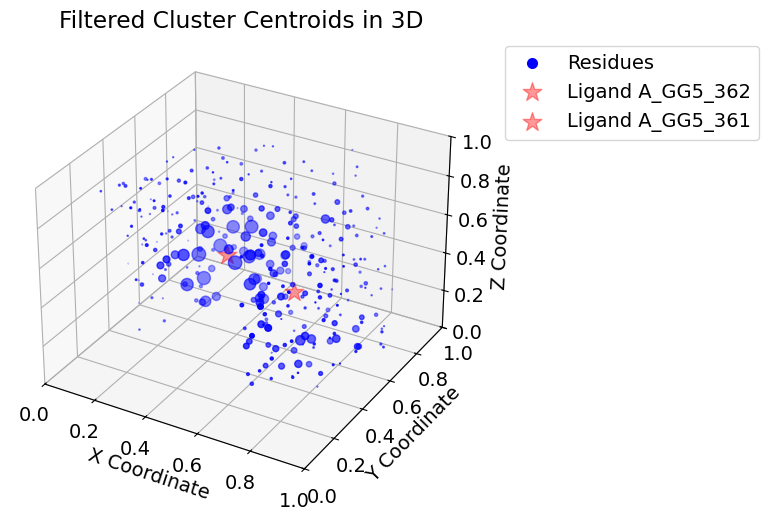

In [ ]:
# Visualize residues with p(bind) = size in 3D
ligand_centers = calculate_ligand_centers(pdb_file)

# Normalize ligand centers using separate scalers for each dimension
ligand_centers_normalized = {
    lig_id: [
        scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
        scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
        scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
    ]
    for lig_id, (x, y, z) in ligand_centers.items()
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot resi in df with the 3D coordinates center_of_mass_x_normalized, center_of_mass_y_normalized, center_of_mass_z_normalized
ax.scatter(df['center_of_mass_x_normalized'], df['center_of_mass_y_normalized'], df['center_of_mass_z_normalized'], 
           s=df[pbind_column] * 100, c='blue', label='Residues')

# Plot ligand centers
for ligand_id, center in ligand_centers_normalized.items():
    ax.scatter(*center, color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("Filtered Cluster Centroids in 3D")

# Set axis limits to 0-1 scale
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

# Sort legend to prioritize clusters over ligands
handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: "Ligand" in x[1]))  # Moves ligands to end
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# Filter the residues based on the pbind cutoff
from numpy import median, std


std_factor = 1
median_value = df[pbind_column].median()
std_value = df[pbind_column].std()
cutoff = median_value + std_factor * std_value

df_filtered = df.loc[df[pbind_column] > cutoff]
print(f"Number of the residual higher than the cutoff{df_filtered.shape}")


Number of the residual higher than the cutoff(54, 20)


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

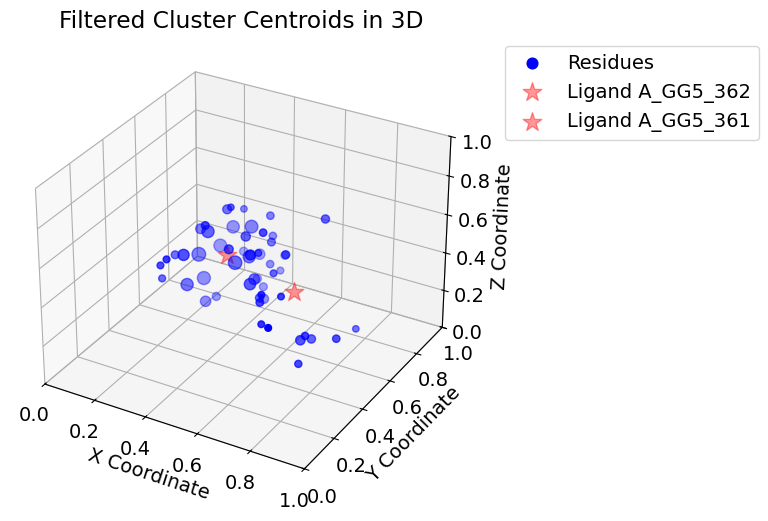

In [ ]:
# Visualize residues with p(bind) = size in 3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot resi in df with the 3D coordinates center_of_mass_x_normalized, center_of_mass_y_normalized, center_of_mass_z_normalized
ax.scatter(df_filtered['center_of_mass_x_normalized'], df_filtered['center_of_mass_y_normalized'], df_filtered['center_of_mass_z_normalized'], 
           s=df_filtered[pbind_column] * 100, c='blue', label='Residues')

# Plot ligand centers
for ligand_id, center in ligand_centers_normalized.items():
    ax.scatter(*center, color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("Filtered Cluster Centroids in 3D")

# Set axis limits to 0-1 scale
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

# Sort legend to prioritize clusters over ligands
handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: "Ligand" in x[1]))  # Moves ligands to end
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# Run clustering on the filtered data
results = {}
centroids = {}
centroid_data = {}  # New dictionary to store centroid data

# Dataframe to store optimal cluster numbers
results_list = []



for weight in pbind_weights:
    weighted_columns = [f"{col}_normalized" for col in feature_columns] + [f"{pbind_column}_weight_{weight}"]


    # 🔹 Step 2: Determine optimal number of clusters
    optimal_kmeans, _ = silhouette_analysis(df_filtered[weighted_columns].values, max_clusters=10)
    optimal_spectral, _ = eigengap_heuristic(df_filtered[weighted_columns].values, max_clusters=10)
    _, optimal_gmm = gmm_clustering(df_filtered, feature_columns=weighted_columns, max_clusters=10)

    # Store the optimal cluster numbers
    results_list.append({
        'pbind_weight': weight,
        'optimal_kmeans': optimal_kmeans,
        'optimal_spectral': optimal_spectral,
        'optimal_gmm': optimal_gmm
    })

    # 🔹 Step 3: Run Clustering with Optimal Clusters
    df_kmeans, kmeans_model = kmeans_clustering(df_filtered, weighted_columns, n_clusters=optimal_kmeans)
    df_spectral, spectral_model = spectral_clustering(df_filtered, weighted_columns, n_clusters=optimal_spectral)
    df_gmm, optimal_gmm_clusters = gmm_clustering(df_filtered, feature_columns=weighted_columns, max_clusters=optimal_gmm)

    # Store cluster labels
    results[f'kmeans_pbind_{weight}'] = df_kmeans['kmeans_cluster']
    results[f'spectral_pbind_{weight}'] = df_spectral['spectral_cluster']
    results[f'gmm_pbind_{weight}'] = df_gmm['gmm_cluster']

    # 🔹 Compute & Store Centroids
    # KMeans centroids
    centroids[f'kmeans_pbind_{weight}'] = kmeans_model.cluster_centers_

    # Spectral clustering centroids (compute mean of points in each cluster)
    spectral_centroids = np.array([
        df_filtered[df_filtered['spectral_cluster'] == i][weighted_columns].mean().values 
        for i in range(optimal_spectral)
    ])
    centroids[f'spectral_pbind_{weight}'] = spectral_centroids

    # GMM centroids
    gmm_centroids = np.array([
        df_filtered[df_filtered['gmm_cluster'] == i][weighted_columns].mean().values 
        for i in range(optimal_gmm)
    ])
    centroids[f'gmm_pbind_{weight}'] = gmm_centroids

    # Store centroid data in a more organized format
    centroid_data[weight] = {
        'kmeans': {
            'centroids': centroids[f'kmeans_pbind_{weight}'],
            'n_clusters': optimal_kmeans
        },
        'spectral': {
            'centroids': centroids[f'spectral_pbind_{weight}'],
            'n_clusters': optimal_spectral
        },
        'gmm': {
            'centroids': centroids[f'gmm_pbind_{weight}'],
            'n_clusters': optimal_gmm
        }
    }
    
# Save centroid data for later use
np.save(f"{data_path}/centroid_data.npy", centroid_data)

# Convert list to DataFrame and display it
results_df = pd.DataFrame(results_list)

# 🔹 Compare Clustering Results
print("\n🔹 Comparing Clustering Results...")
for name, clusters in results.items():
    print(f"{name}:")
    print(clusters.value_counts(), "\n")



# Save centroid data for later use
np.save(f"{data_path}/centroid_data.npy", centroid_data)


Suggested number of clusters (Silhouette): 4
Silhouette Scores: [0.3275199752633735, 0.318864946416632, 0.353051802765197, 0.3459807351397049, 0.34881876821981017, 0.34092458867530195, 0.3041891727866996, 0.3067997360143117, 0.2537728462699949]
Optimal number of clusters (Eigengap): 1
Eigengaps: [0.38647238 0.06923868 0.06656129 0.05403407 0.2145988  0.04620094
 0.17363384 0.02579775 0.03587597]
Optimal number of clusters (BIC): 1
Optimal number of clusters (BIC): 1
Suggested number of clusters (Silhouette): 2
Silhouette Scores: [0.6651350996296651, 0.5406618710250409, 0.3720496392743267, 0.35516056648347455, 0.3377028690440551, 0.3305722811585412, 0.29593035966856435, 0.3048777926485517, 0.30749540083741256]
Optimal number of clusters (Eigengap): 5
Eigengaps: [0.08836261 0.08994018 0.14835577 0.07161667 0.16006234 0.04912842
 0.06681204 0.14588448 0.03711703]
Optimal number of clusters (BIC): 1
Optimal number of clusters (BIC): 1


/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_32427/552857459.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gmm_cluster'] = gmm.fit_predict(augmented_data)
/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_32427/552857459.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmeans_cluster'] = kmeans.fit_predict(features)
/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_32427/552857459.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Suggested number of clusters (Silhouette): 2
Silhouette Scores: [0.7067913204067467, 0.6224028940774355, 0.4742737963454245, 0.4660086274546088, 0.45157201452317014, 0.380085100335793, 0.38665293988914734, 0.39922604306028336, 0.403889090129732]
Optimal number of clusters (Eigengap): 1
Eigengaps: [0.2858854  0.04738168 0.10805455 0.151609   0.18817205 0.07120267
 0.09836284 0.05469998 0.08958044]
Optimal number of clusters (BIC): 1
Optimal number of clusters (BIC): 1
Suggested number of clusters (Silhouette): 2
Silhouette Scores: [0.7296145030771379, 0.673862743333288, 0.5756602987903163, 0.6122712419676302, 0.5930775981313592, 0.5880200122340553, 0.6264611404357978, 0.6236856920800837, 0.6504811987351893]
Optimal number of clusters (Eigengap): 7
Eigengaps: [0.03323866 0.05649704 0.04935638 0.161895   0.20456778 0.04754473
 0.24229161 0.0552114  0.05930449]
Optimal number of clusters (BIC): 1
Optimal number of clusters (BIC): 1

🔹 Comparing Clustering Results...
kmeans_pbind_1:
kmeans_

/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_32427/552857459.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gmm_cluster'] = gmm.fit_predict(augmented_data)
/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_32427/552857459.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmeans_cluster'] = kmeans.fit_predict(features)
/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_32427/552857459.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [ ]:
def run_clustering_analysis(df, feature_columns, pbind_column, pbind_weights, median_std_factor):
    """
    Performs clustering analysis using different algorithms (KMeans, Spectral, GMM) with varying p(bind) weights.
    
    Args:
        df_filtered (pd.DataFrame): Filtered DataFrame with features
        feature_columns (list): List of feature column names
        pbind_column (str): Name of the p(bind) column
        pbind_weights (list): List of weights to apply to p(bind)
        
    Returns:
        tuple: (results, centroids, centroid_data, results_df)
            - results: Dictionary of cluster assignments for each method/weight
            - centroids: Dictionary of centroids for each method/weight
            - centroid_data: Structured dictionary of clustering results
            - results_df: DataFrame summarizing optimal cluster counts
    """
    results = {}
    centroids = {}
    centroid_data = {}
    results_list = []

    std_factor = 1
    

    

    for median_filter_factor in median_std_factor:
        median_value = df[pbind_column].median()
        std_value = df[pbind_column].std()
        cutoff = median_value + median_filter_factor * std_value
        df_filtered = df.loc[df[pbind_column] > cutoff]
        print(f"Number of the residual higher than the cutoff{df_filtered.shape}")
        
        for weight in pbind_weights:
            weighted_columns = [f"{col}_normalized" for col in feature_columns] + [f"{pbind_column}_weight_{weight}"]

            # Determine optimal number of clusters
            optimal_kmeans, _ = silhouette_analysis(df_filtered[weighted_columns].values, max_clusters=10)
            optimal_spectral, _ = eigengap_heuristic(df_filtered[weighted_columns].values, max_clusters=10)
            _, optimal_gmm = gmm_clustering(df_filtered, feature_columns=weighted_columns, max_clusters=10)

            # Store the optimal cluster numbers
            results_list.append({
                'pbind_weight': weight,
                'optimal_kmeans': optimal_kmeans,
                'optimal_spectral': optimal_spectral,
                'optimal_gmm': optimal_gmm
            })

            # Run Clustering with Optimal Clusters
            df_kmeans, kmeans_model = kmeans_clustering(df_filtered, weighted_columns, n_clusters=optimal_kmeans)
            df_spectral, spectral_model = spectral_clustering(df_filtered, weighted_columns, n_clusters=optimal_spectral)
            df_gmm, optimal_gmm_clusters = gmm_clustering(df_filtered, feature_columns=weighted_columns, max_clusters=optimal_gmm)

            # Store cluster labels
            results[f'kmeans_pbind_{weight}'] = df_kmeans['kmeans_cluster']
            results[f'spectral_pbind_{weight}'] = df_spectral['spectral_cluster']
            results[f'gmm_pbind_{weight}'] = df_gmm['gmm_cluster']

            # Compute & Store Centroids
            # KMeans centroids
            centroids[f'kmeans_pbind_{weight}'] = kmeans_model.cluster_centers_

            # Spectral clustering centroids (compute mean of points in each cluster)
            spectral_centroids = np.array([
                df_filtered[df_filtered['spectral_cluster'] == i][weighted_columns].mean().values 
                for i in range(optimal_spectral)
            ])
            centroids[f'spectral_pbind_{weight}'] = spectral_centroids

            # GMM centroids
            gmm_centroids = np.array([
                df_filtered[df_filtered['gmm_cluster'] == i][weighted_columns].mean().values 
                for i in range(optimal_gmm)
            ])
            centroids[f'gmm_pbind_{weight}'] = gmm_centroids

            # Store centroid data in a more organized format
            centroid_data[weight] = {
                'kmeans': {
                    'centroids': centroids[f'kmeans_pbind_{weight}'],
                    'n_clusters': optimal_kmeans
                },
                'spectral': {
                    'centroids': centroids[f'spectral_pbind_{weight}'],
                    'n_clusters': optimal_spectral
                },
                'gmm': {
                    'centroids': centroids[f'gmm_pbind_{weight}'],
                    'n_clusters': optimal_gmm
                }
            }
    
    # Convert results list to DataFrame
    results_df = pd.DataFrame(results_list)
    
    return results, centroids, centroid_data, results_df

# Example usage
results, centroids, centroid_data, results_df = run_clustering_analysis(df_filtered, feature_columns, pbind_column, pbind_weights)

NameError: name 'df_filtered' is not defined

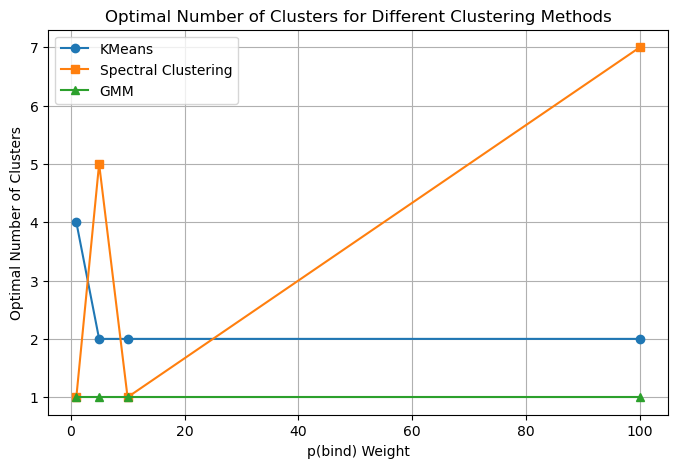

In [18]:
# 🔹 Visualize Optimal Cluster Numbers
plt.figure(figsize=(8, 5))
plt.plot(results_df['pbind_weight'], results_df['optimal_kmeans'], marker='o', label='KMeans')
plt.plot(results_df['pbind_weight'], results_df['optimal_spectral'], marker='s', label='Spectral Clustering')
plt.plot(results_df['pbind_weight'], results_df['optimal_gmm'], marker='^', label='GMM')

plt.xlabel('p(bind) Weight')
plt.ylabel('Optimal Number of Clusters')
plt.title('Optimal Number of Clusters for Different Clustering Methods')
plt.legend()
plt.grid()
plt.show()

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

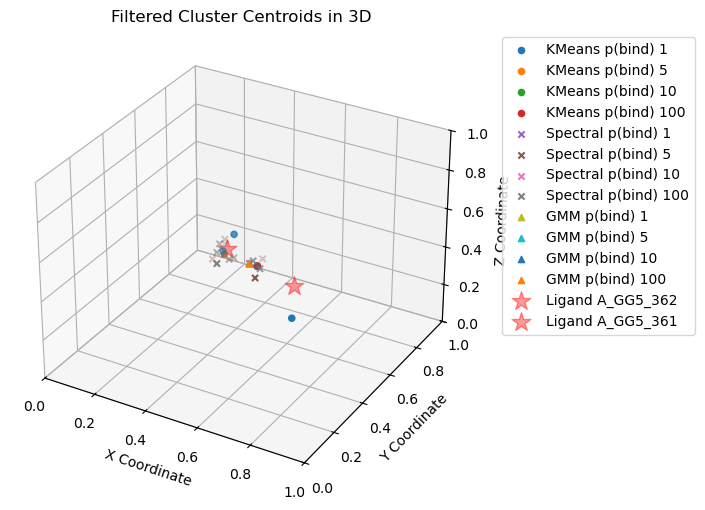

In [19]:
# 🔹 Step 7: Visualize Cluster Centroids in 3D
ligand_centers = calculate_ligand_centers(pdb_file)

# Normalize ligand centers using separate scalers for each dimension
ligand_centers_normalized = {
    lig_id: [
        scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
        scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
        scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
    ]
    for lig_id, (x, y, z) in ligand_centers.items()
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot centroids for KMeans
for weight in pbind_weights:
    ax.scatter(*centroids[f'kmeans_pbind_{weight}'][:, :3].T, label=f"KMeans p(bind) {weight}", marker='o')

# Plot centroids for Spectral Clustering
for weight in pbind_weights:
    ax.scatter(*centroids[f'spectral_pbind_{weight}'][:, :3].T, label=f"Spectral p(bind) {weight}", marker='x')

# Plot centroids for GMM
for weight in pbind_weights:
    ax.scatter(*centroids[f'gmm_pbind_{weight}'][:, :3].T, label=f"GMM p(bind) {weight}", marker='^')

# Plot ligand centers (Sent to Back for Visibility)
for ligand_id, center in ligand_centers_normalized.items():
    ax.scatter(*center, color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("Filtered Cluster Centroids in 3D")

# Set axis limits to 0-1 scale
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

# Sort legend to prioritize clusters over ligands
handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: "Ligand" in x[1]))  # Moves ligands to end
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

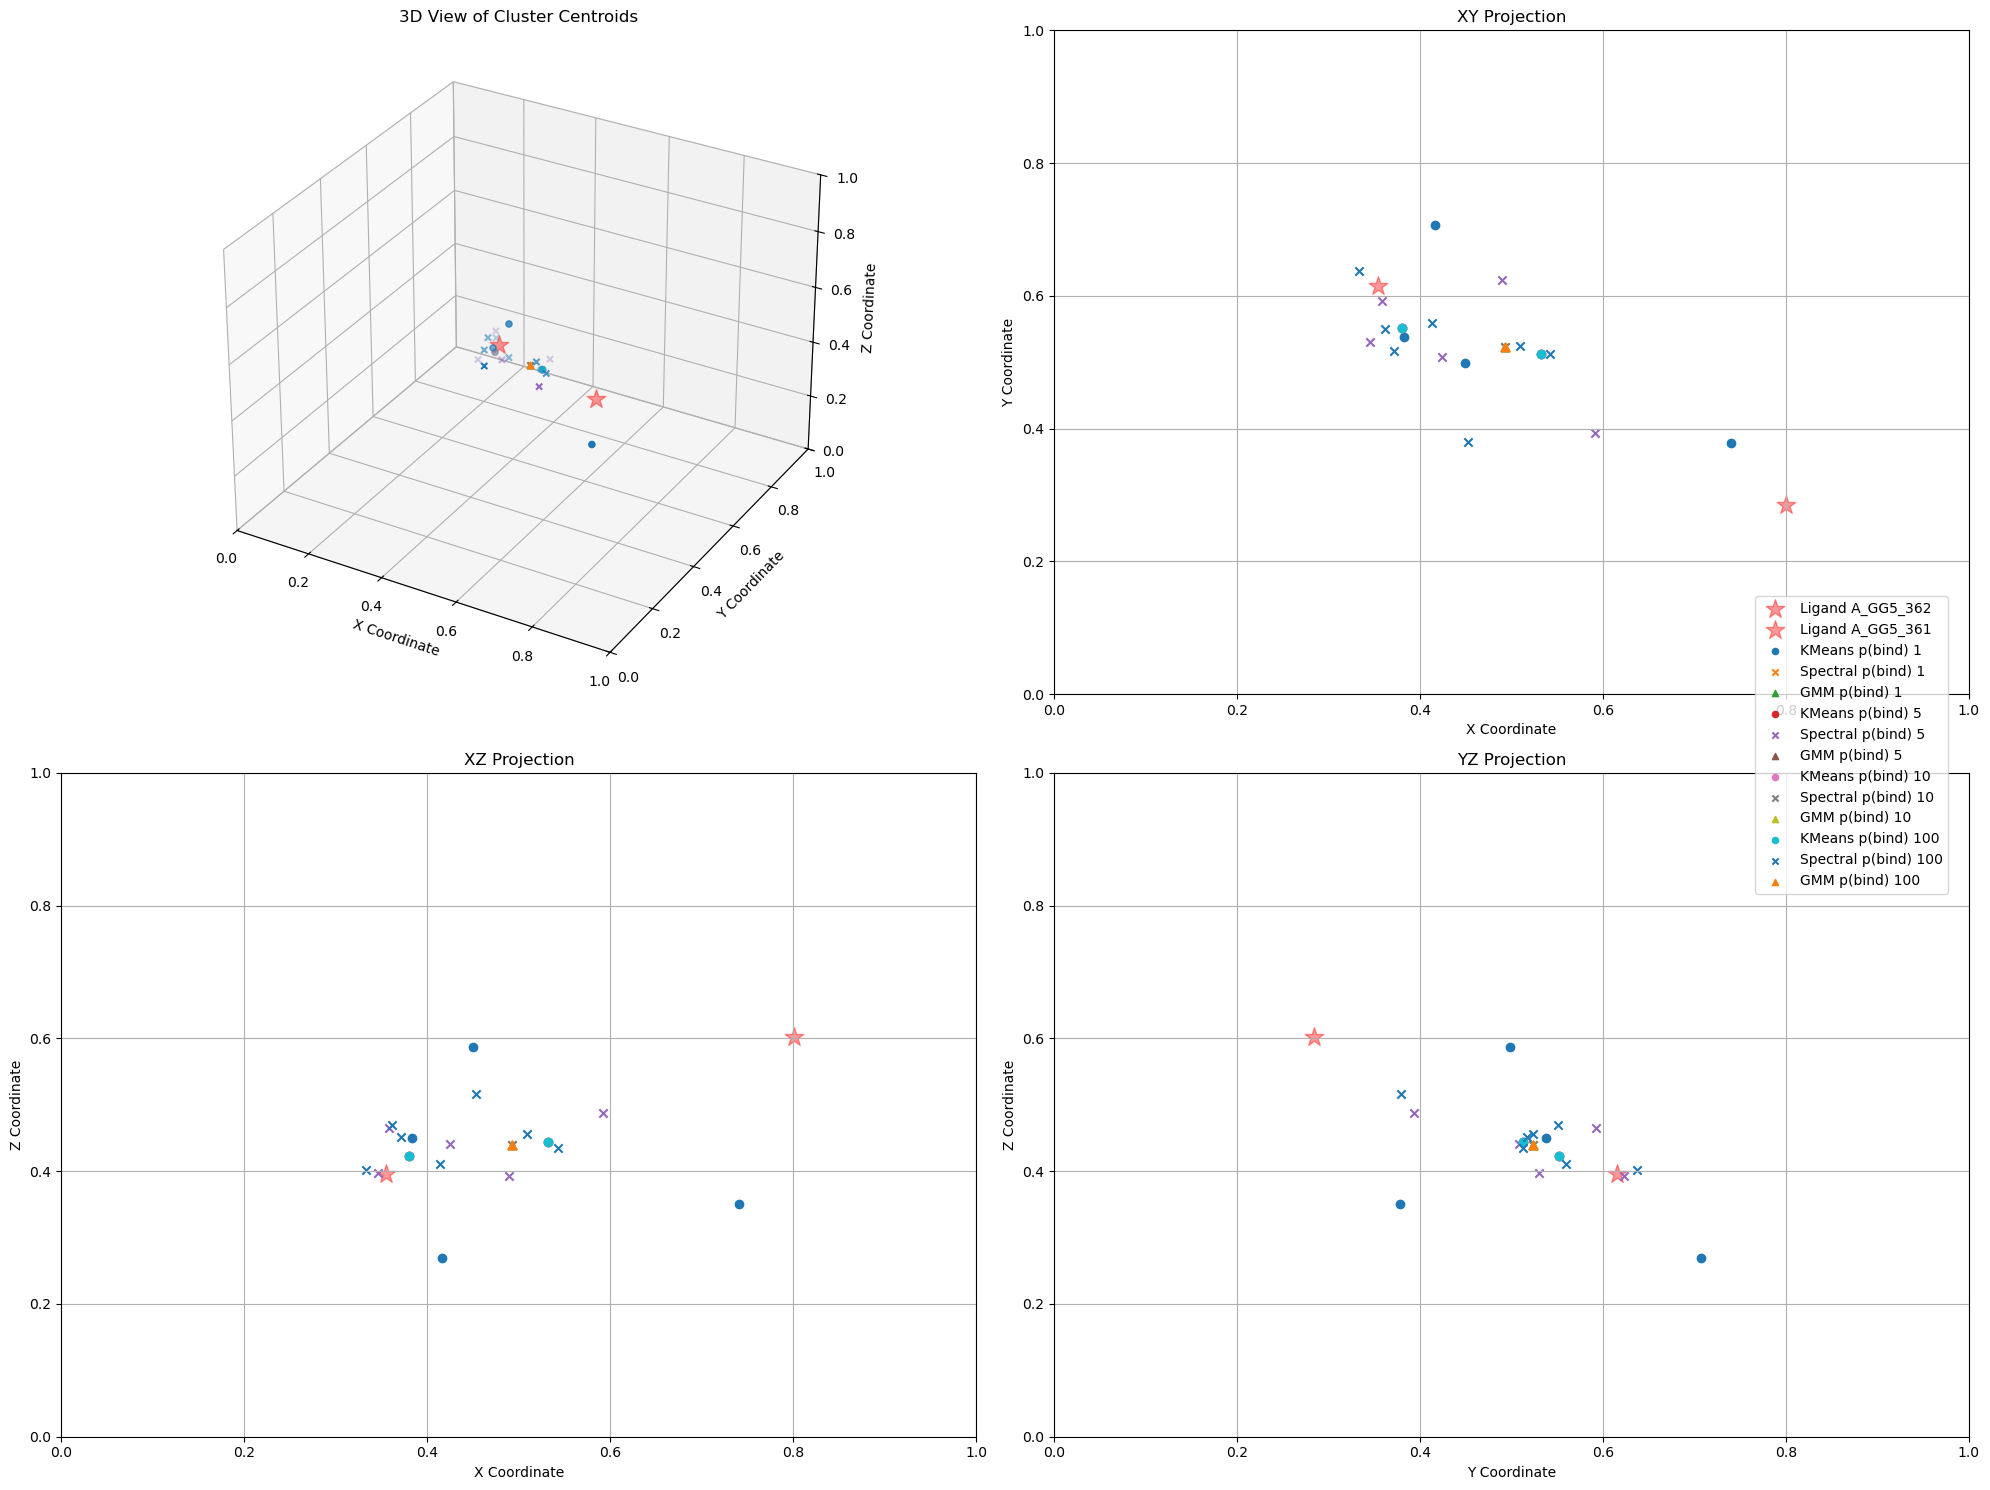

In [23]:
# Create 2D plots for each pairwise axis combination along with the 3D plot
fig = plt.figure(figsize=(20, 15))

# 3D plot (top left)
ax3d = fig.add_subplot(221, projection='3d')

# Plot ligand centers in 3D
for ligand_id, center in ligand_centers_normalized.items():
    ax3d.scatter(*center, color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

# Plot centroids in 3D
for weight in pbind_weights:
    centroids_array = centroids[f'kmeans_pbind_{weight}']
    if centroids_array.size > 0:
        ax3d.scatter(*centroids_array[:, :3].T, label=f"KMeans p(bind) {weight}", marker='o')
    
    centroids_array = centroids[f'spectral_pbind_{weight}']
    if centroids_array.size > 0:
        ax3d.scatter(*centroids_array[:, :3].T, label=f"Spectral p(bind) {weight}", marker='x')
    
    centroids_array = centroids[f'gmm_pbind_{weight}']
    if centroids_array.size > 0:
        ax3d.scatter(*centroids_array[:, :3].T, label=f"GMM p(bind) {weight}", marker='^')

ax3d.set_xlabel("X Coordinate")
ax3d.set_ylabel("Y Coordinate")
ax3d.set_zlabel("Z Coordinate")
ax3d.set_title("3D View of Cluster Centroids")
ax3d.set_xlim([0, 1])
ax3d.set_ylim([0, 1])
ax3d.set_zlim([0, 1])

# XY plot (top right)
ax_xy = fig.add_subplot(222)
for ligand_id, center in ligand_centers_normalized.items():
    ax_xy.scatter(center[0], center[1], color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

for weight in pbind_weights:
    for method in ['kmeans', 'spectral', 'gmm']:
        centroids_array = centroids[f'{method}_pbind_{weight}']
        if centroids_array.size > 0:
            marker = 'o' if method == 'kmeans' else ('x' if method == 'spectral' else '^')
            ax_xy.scatter(centroids_array[:, 0], centroids_array[:, 1], 
                         label=f"{method} p(bind) {weight}", marker=marker)

ax_xy.set_xlabel("X Coordinate")
ax_xy.set_ylabel("Y Coordinate")
ax_xy.set_title("XY Projection")
ax_xy.grid(True)
ax_xy.set_xlim([0, 1])
ax_xy.set_ylim([0, 1])

# XZ plot (bottom left)
ax_xz = fig.add_subplot(223)
for ligand_id, center in ligand_centers_normalized.items():
    ax_xz.scatter(center[0], center[2], color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

for weight in pbind_weights:
    for method in ['kmeans', 'spectral', 'gmm']:
        centroids_array = centroids[f'{method}_pbind_{weight}']
        if centroids_array.size > 0:
            marker = 'o' if method == 'kmeans' else ('x' if method == 'spectral' else '^')
            ax_xz.scatter(centroids_array[:, 0], centroids_array[:, 2], 
                         label=f"{method} p(bind) {weight}", marker=marker)

ax_xz.set_xlabel("X Coordinate")
ax_xz.set_ylabel("Z Coordinate")
ax_xz.set_title("XZ Projection")
ax_xz.grid(True)
ax_xz.set_xlim([0, 1])
ax_xz.set_ylim([0, 1])

# YZ plot (bottom right)
ax_yz = fig.add_subplot(224)
for ligand_id, center in ligand_centers_normalized.items():
    ax_yz.scatter(center[1], center[2], color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

for weight in pbind_weights:
    for method in ['kmeans', 'spectral', 'gmm']:
        centroids_array = centroids[f'{method}_pbind_{weight}']
        if centroids_array.size > 0:
            marker = 'o' if method == 'kmeans' else ('x' if method == 'spectral' else '^')
            ax_yz.scatter(centroids_array[:, 1], centroids_array[:, 2], 
                         label=f"{method} p(bind) {weight}", marker=marker)

ax_yz.set_xlabel("Y Coordinate")
ax_yz.set_ylabel("Z Coordinate")
ax_yz.set_title("YZ Projection")
ax_yz.grid(True)
ax_yz.set_xlim([0, 1])
ax_yz.set_ylim([0, 1])

# Adjust layout and add legend
plt.tight_layout()
handles, labels = ax3d.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))
plt.show()

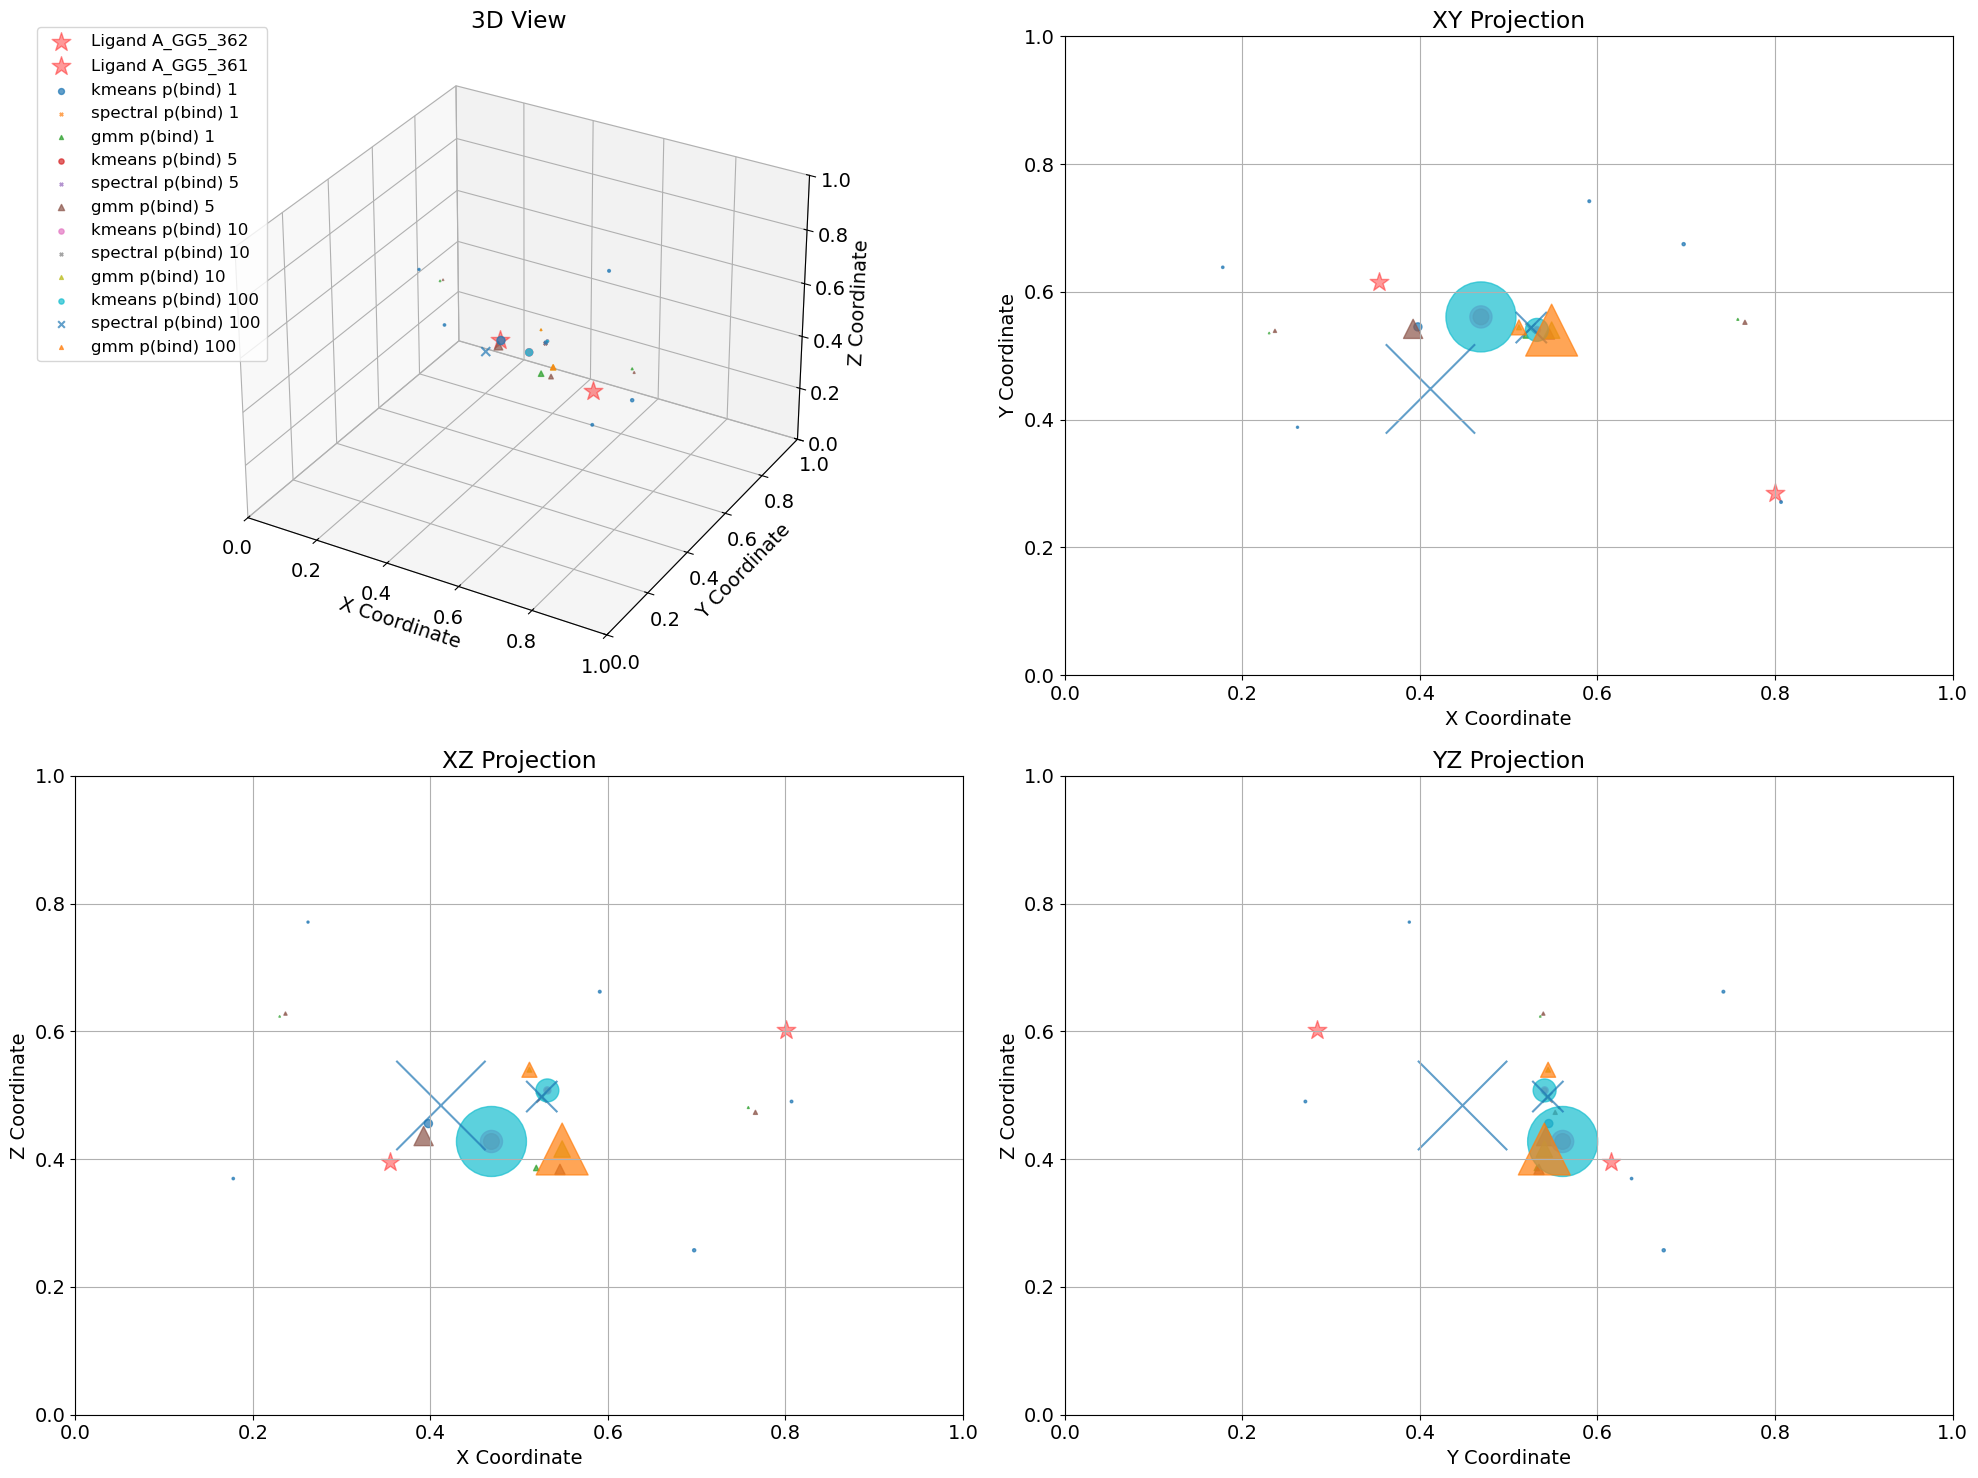

In [ ]:
# Size = p(bind): Create 2D plots for each pairwise axis combination along with the 3D plot
plt.rcParams.update({'font.size': 14})  # Increase base font size
fig = plt.figure(figsize=(20, 15))

# 3D plot (top left)
ax3d = fig.add_subplot(221, projection='3d')

# Plot ligand centers in 3D (background)
for ligand_id, center in ligand_centers_normalized.items():
    ax3d.scatter(*center, color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

# Plot centroids with size proportional to mean p(bind)
size_scale = 50 # Scale factor for marker sizes
for weight in pbind_weights:
    for method, marker in zip(['kmeans', 'spectral', 'gmm'], ['o', 'x', '^']):
        method_key = f'{method}_pbind_{weight}'
        if method_key in centroids and centroids[method_key].shape[1] > 3:
            spatial_coords = centroids[method_key][:, :3]
            mean_pbinds = centroids[method_key][:, -1]/weight
            sizes = mean_pbinds * size_scale
            
            ax3d.scatter(*spatial_coords.T, 
                      s=sizes,
                      marker=marker, 
                      label=f"{method} p(bind) {weight}",
                      alpha=0.7)

ax3d.set_xlabel("X Coordinate")
ax3d.set_ylabel("Y Coordinate")
ax3d.set_zlabel("Z Coordinate")
ax3d.set_title("3D View")
ax3d.set_xlim(0, 1)
ax3d.set_ylim(0, 1)
ax3d.set_zlim(0, 1)

# XY projection (top right)
ax_xy = fig.add_subplot(222)
for ligand_id, center in ligand_centers_normalized.items():
    ax_xy.scatter(center[0], center[1], color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

for weight in pbind_weights:
    for method, marker in zip(['kmeans', 'spectral', 'gmm'], ['o', 'x', '^']):
        method_key = f'{method}_pbind_{weight}'
        if method_key in centroids and centroids[method_key].shape[1] > 3:
            spatial_coords = centroids[method_key][:, :3]
            mean_pbinds = centroids[method_key][:, -1]
            sizes = mean_pbinds * size_scale
            ax_xy.scatter(spatial_coords[:, 0], spatial_coords[:, 1],
                       s=sizes,
                       marker=marker,
                       label=f"{method} p(bind) {weight}",
                       alpha=0.7)

ax_xy.set_xlabel("X Coordinate")
ax_xy.set_ylabel("Y Coordinate")
ax_xy.set_title("XY Projection")
ax_xy.grid(True)
ax_xy.set_xlim(0, 1)
ax_xy.set_ylim(0, 1)

# XZ projection (bottom left)
ax_xz = fig.add_subplot(223)
for ligand_id, center in ligand_centers_normalized.items():
    ax_xz.scatter(center[0], center[2], color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

for weight in pbind_weights:
    for method, marker in zip(['kmeans', 'spectral', 'gmm'], ['o', 'x', '^']):
        method_key = f'{method}_pbind_{weight}'
        if method_key in centroids and centroids[method_key].shape[1] > 3:
            spatial_coords = centroids[method_key][:, :3]
            mean_pbinds = centroids[method_key][:, -1]
            sizes = mean_pbinds * size_scale
            ax_xz.scatter(spatial_coords[:, 0], spatial_coords[:, 2],
                       s=sizes,
                       marker=marker,
                       label=f"{method} p(bind) {weight}",
                       alpha=0.7)

ax_xz.set_xlabel("X Coordinate")
ax_xz.set_ylabel("Z Coordinate")
ax_xz.set_title("XZ Projection")
ax_xz.grid(True)
ax_xz.set_xlim(0, 1)
ax_xz.set_ylim(0, 1)

# YZ projection (bottom right)
ax_yz = fig.add_subplot(224)
for ligand_id, center in ligand_centers_normalized.items():
    ax_yz.scatter(center[1], center[2], color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

for weight in pbind_weights:
    for method, marker in zip(['kmeans', 'spectral', 'gmm'], ['o', 'x', '^']):
        method_key = f'{method}_pbind_{weight}'
        if method_key in centroids and centroids[method_key].shape[1] > 3:
            spatial_coords = centroids[method_key][:, :3]
            mean_pbinds = centroids[method_key][:, -1]
            sizes = mean_pbinds * size_scale
            ax_yz.scatter(spatial_coords[:, 1], spatial_coords[:, 2],
                       s=sizes,
                       marker=marker,
                       label=f"{method} p(bind) {weight}",
                       alpha=0.7)

ax_yz.set_xlabel("Y Coordinate")
ax_yz.set_ylabel("Z Coordinate")
ax_yz.set_title("YZ Projection")
ax_yz.grid(True)
ax_yz.set_xlim(0, 1)
ax_yz.set_ylim(0, 1)

# Adjust layout and add legend
plt.tight_layout()
handles, labels = ax3d.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize=12)
plt.show()